In [28]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn

from tqdm import tqdm
from random import shuffle
from sklearn.metrics import f1_score

from dataloader import load_data, CustomDataset
from model import init_model, train

In [2]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})

In [3]:
# set device to GPU
dev = "cuda:0"

In [4]:
# load all data
(
    train_data, val_data, test_data,
    patches, frames_idx, 
    county_data,
    counties_time_grid,
    precip_time_grid,
    tpi_array,
    landcover_array,
    scores_time_grid,
    night_time_grid,
    sentinel_time_grid
) = load_data()

Creating counties defor time grid: 28it [00:04,  6.37it/s]
Creating precipitations time grid: 28it [00:04,  6.74it/s]
Creating scores time grid: 28it [00:01, 27.71it/s]
Creating night lights time grid: 28it [00:06,  4.04it/s]
Creating sentinel time grid: 28it [00:03,  8.51it/s]
Computing patches: 100%|██████████| 32/32 [00:20<00:00,  1.59it/s]


In [5]:
# channels to be used
channels = [0, 1, 2, 3, 5, 23, 21, 10, 7, 11, 16, 24]

In [6]:
trainloader = torch.utils.data.DataLoader(
    CustomDataset(
        train_data, 
        patches, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid,
        night_time_grid,
        sentinel_time_grid,
        channels
    ),
    batch_size=64,
    shuffle=True
)

valloader = torch.utils.data.DataLoader(
    CustomDataset(
        val_data, 
        patches, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid,
        night_time_grid,
        sentinel_time_grid,
        channels
    ),
    batch_size=1000,
    shuffle=True
)

valloader = torch.utils.data.DataLoader(
    CustomDataset(
        test_data, 
        patches, 
        frames_idx, 
        county_data,
        counties_time_grid,
        precip_time_grid,
        tpi_array,
        landcover_array,
        scores_time_grid,
        night_time_grid,
        sentinel_time_grid,
        channels
    ),
    batch_size=1000,
    shuffle=True
)

In [7]:
# train model
n_epochs = 15
model, optimizer = init_model(len(channels))
train(model, optimizer, n_epochs, trainloader, valloader)


Epoch 1


100%|██████████| 54/54 [00:16<00:00,  3.37it/s]


Epoch 1: Train Loss = 0.009605 | Validation Loss = 0.005177

Epoch 2


100%|██████████| 54/54 [00:15<00:00,  3.50it/s]


Epoch 2: Train Loss = 0.004141 | Validation Loss = 0.004430

Epoch 3


100%|██████████| 54/54 [00:14<00:00,  3.69it/s]


Epoch 3: Train Loss = 0.003585 | Validation Loss = 0.004128

Epoch 4


100%|██████████| 54/54 [00:14<00:00,  3.70it/s]


Epoch 4: Train Loss = 0.003349 | Validation Loss = 0.003979

Epoch 5


100%|██████████| 54/54 [00:14<00:00,  3.64it/s]


Epoch 5: Train Loss = 0.003173 | Validation Loss = 0.003835

Epoch 6


100%|██████████| 54/54 [00:15<00:00,  3.46it/s]


Epoch 6: Train Loss = 0.003054 | Validation Loss = 0.003738

Epoch 7


100%|██████████| 54/54 [00:14<00:00,  3.70it/s]


Epoch 7: Train Loss = 0.003005 | Validation Loss = 0.003665

Epoch 8


100%|██████████| 54/54 [00:15<00:00,  3.53it/s]


Epoch 8: Train Loss = 0.002922 | Validation Loss = 0.003669

Epoch 9


100%|██████████| 54/54 [00:15<00:00,  3.45it/s]


Epoch 9: Train Loss = 0.002852 | Validation Loss = 0.003631

Epoch 10


100%|██████████| 54/54 [00:15<00:00,  3.53it/s]


Epoch 10: Train Loss = 0.002792 | Validation Loss = 0.003597

Epoch 11


100%|██████████| 54/54 [00:15<00:00,  3.53it/s]


Epoch 11: Train Loss = 0.002741 | Validation Loss = 0.003552

Epoch 12


100%|██████████| 54/54 [00:14<00:00,  3.68it/s]


Epoch 12: Train Loss = 0.002693 | Validation Loss = 0.003557

Epoch 13


100%|██████████| 54/54 [00:14<00:00,  3.66it/s]


Epoch 13: Train Loss = 0.002661 | Validation Loss = 0.003585

Epoch 14


100%|██████████| 54/54 [00:14<00:00,  3.74it/s]


Epoch 14: Train Loss = 0.002624 | Validation Loss = 0.003501

Epoch 15


100%|██████████| 54/54 [00:14<00:00,  3.76it/s]


Epoch 15: Train Loss = 0.002600 | Validation Loss = 0.003493


# Learning curves

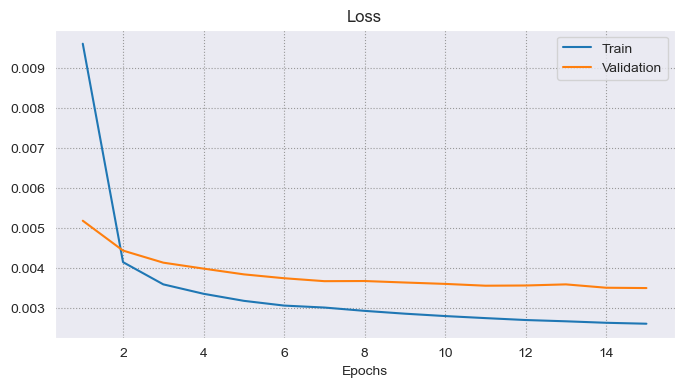

In [8]:
fig, ax = plt.subplots(figsize=(8, 4))
x = np.array(range(len(model.errs))) + 1
sns.lineplot(x=x, y=[float(e[0]) for e in model.errs], label="Train")
sns.lineplot(x=x, y=[float(e[1]) for e in model.errs], label="Validation")
ax.set_title("Loss")
ax.set_xlabel("Epochs")
plt.show()

# Confusion Matrix

In [9]:
# softmax function will be needed
softmax_ = nn.Softmax(dim=1)

## Train

In [10]:
# get prediction values as binary
y_true = []
y_pred = []
for inputs, labels in trainloader:
    y_hat = model(inputs).detach()
    y_true.append(labels[:, 1, :, :].cpu())
    y_pred.append(softmax_(y_hat)[:, 1, :, :].cpu())

In [11]:
# flatten
y_true = np.concatenate(y_true).flatten() 
y_pred = np.concatenate(y_pred).flatten()

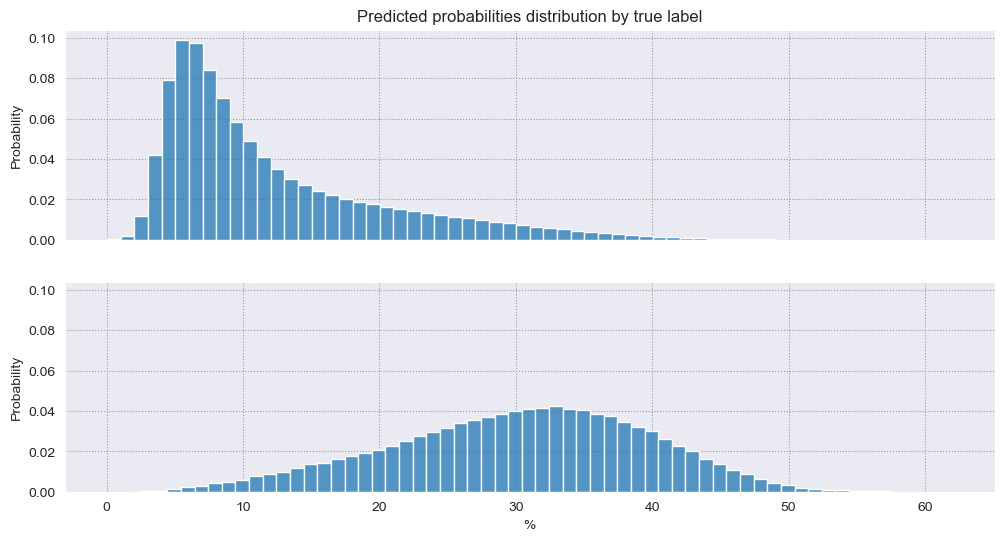

In [12]:
fig, ax = plt.subplots(2, figsize=(12, 6), sharex=True, sharey=True)
sns.histplot(100*y_pred[np.where(y_true==0)], binwidth=1, ax=ax[0], stat="probability")
sns.histplot(100*y_pred[np.where(y_true==1)], binwidth=1, ax=ax[1], stat="probability")
ax[0].set_title("Predicted probabilities distribution by true label")
ax[1].set_xlabel("%")
plt.show()

In [13]:
# select probability treshold
scores = []
for p_treshold in tqdm(range(27, 37)):
    scores.append(
        f1_score(
            y_true, 
            y_pred > p_treshold / 100
        )
    )

100%|██████████| 10/10 [00:42<00:00,  4.20s/it]


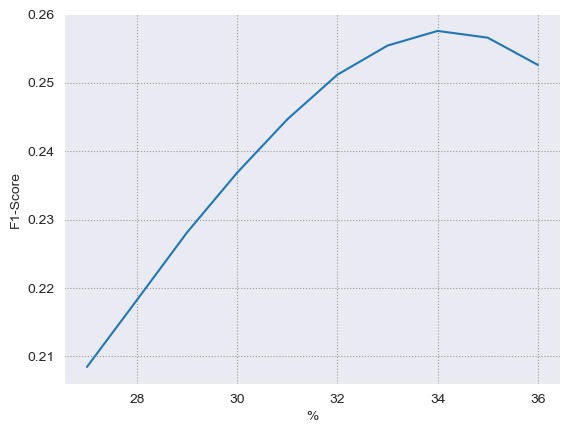

In [15]:
g = sns.lineplot(x=range(27, 37), y=scores)
g.set_xlabel("%")
g.set_ylabel("F1-Score")
plt.show()

In [19]:
# apply confusion matrix with probability treshold
p_treshold = 0.34

from sklearn.metrics import confusion_matrix
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="true"
)

array([[0.97481095, 0.02518905],
       [0.63047393, 0.36952607]])

In [21]:
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="pred"
)

array([[0.98925597, 0.80234555],
       [0.01074403, 0.19765445]])

## Validation

In [22]:
# get prediction values as binary
y_true = []
y_pred = []
for inputs, labels in valloader:
    y_hat = model(inputs).detach()
    y_true.append(labels[:, 1, :, :].cpu())
    y_pred.append(softmax_(y_hat)[:, 1, :, :].cpu())

In [23]:
# flatten
y_true = np.concatenate(y_true).flatten() 
y_pred = np.concatenate(y_pred).flatten()

In [24]:
f1_score(
    y_true, 
    y_pred > p_treshold
)

0.2243814080835103

In [25]:
confusion_matrix(
    y_true, 
    y_pred > p_treshold,
    normalize="true"
)

array([[0.97365538, 0.02634462],
       [0.72749814, 0.27250186]])

# Prediction example

In [29]:
def get_sample(min_area=0.1, dataloader=trainloader):
    for input_, truth in dataloader:
        batches = list(range(truth.shape[0])) 
        shuffle(batches)
        for idx_batch in batches:
            if truth[idx_batch, 1, :, :].mean() > min_area:
                return input_, truth, idx_batch

In [30]:
input_, truth, idx_batch = get_sample(0.05, valloader)

pred = model(input_)

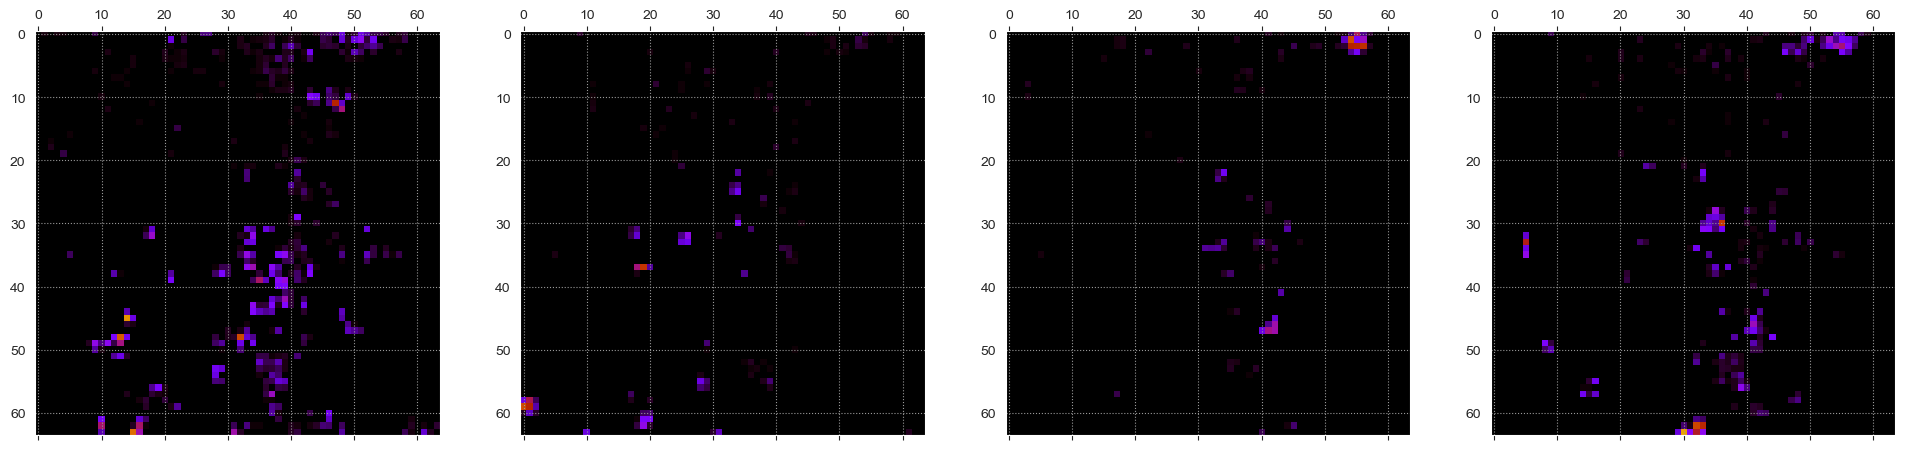

In [31]:
fig, ax = plt.subplots(1, 4, figsize=(24, 8))
for i in range(4):
    ax[i].matshow(input_[idx_batch, i, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
plt.show()

C:\Users\giovanni\AppData\Local\Temp\ipykernel_2112\3254665491.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


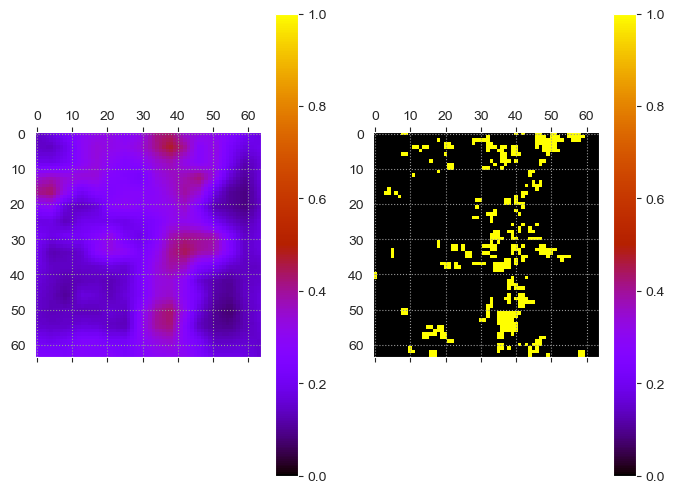

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
m1 = ax[1].matshow(truth[idx_batch, 1, :, :].cpu(), cmap="gnuplot", vmin=truth.min(), vmax=truth.max())
m2 = ax[0].matshow(softmax_(pred).detach().cpu().numpy()[idx_batch, 1, :, :], cmap="gnuplot", vmin=truth.min(), vmax=1)
fig.colorbar(m1)
fig.colorbar(m2)
fig.show()

# Save model

In [33]:
torch.save(model.state_dict(), r"DeepLabV3+_train.pt")